# Bibliotecas Utilizadas

Time: medição de tempo de execução para graficos comparativos
Plotly: plotagem das figuras animadas e graficos

In [216]:
import time
import plotly.graph_objects as go

# Classes Base

A classe Vertex representa cada um dos vértices passados pela entrada e armazena as coordenadas do vertice, o indice dele, a cor dele e os indices de seus vizinhos.


In [217]:
class Vertex:
    def __init__(self,x_coord, y_coord,next_index, prev_index, index):
        self.x = x_coord
        self.y = y_coord
        self.next = next_index
        self.prev = prev_index
        self.index = index
        self.color = None


A classe Polygon representa o poligono passado na entrada, ela armazena a lista de vertices que formam o poligono, a lista de coordenadas x e a lista de coordenadas y. Como funções possui a init responsável pela leitura do arquivo de entrada e criação dos vertices. E a função plot, responsável por exibir o poligono e seu processo de triangulação.

In [218]:
class Polygon:
    def __init__(self, filename):
        self.x_coords = []
        self.y_coords = []
        self.vertex_list = []
        with open(filename, 'r') as file:
            for line in file:
                parts = line.strip().split()
                num_vertices = int(parts[0])
                #print(num_vertices)
                for i in range(num_vertices):
                    x_str, y_str = parts[2 * i + 1], parts[2 * i + 2]
                    num, dem = map(int, x_str.split('/'))
                    x_coord = num / dem
                    self.x_coords.append(x_coord)
                    num, dem = map(int, y_str.split('/'))
                    y_coord = num / dem
                    self.y_coords.append(y_coord)
                    self.vertex_list.append(Vertex(x_coord, y_coord, (i+1)%num_vertices, (i-1)%num_vertices , i))
    
    def plot(self, triangles=None):
        fig = go.Figure()
    
        fig.add_trace(go.Scatter(x=self.x_coords + [self.x_coords[0]], y=self.y_coords + [self.y_coords[0]], fill='toself', fillcolor='rgba(0, 0, 139, 0.2)',
                                 mode='lines+markers', name='Triangle'))
    
    
        fig.update_layout(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            showlegend=True,
            hovermode='closest',
            template='plotly_white',
            updatemenus=[{'type': 'buttons',
                          'buttons': [{'label': 'Play',
                                       'method': 'animate',
                                       'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}]},
                                     {'label': 'Pause',
                                      'method': 'animate',
                                      'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate', 'transition': {'duration': 0}}]}]}]
        )
        if triangles:
            frames = []
            fig.add_trace(go.Scatter(x=self.x_coords + [self.x_coords[0]], y=self.y_coords + [self.y_coords[0]], fill='toself', fillcolor='rgba(34, 200, 255, 0.2)',
                                     mode='lines+markers', name='Polygon'))

            triangles_x = []
            triangles_y = []

            for i, triangle in enumerate(triangles):
                triangle_x = [triangle[0].x, triangle[1].x, triangle[2].x, triangle[0].x]
                triangle_y = [triangle[0].y, triangle[1].y, triangle[2].y, triangle[0].y]


                triangles_x.extend(triangle_x + [None])
                triangles_y.extend(triangle_y + [None])

                frame = go.Frame(data=[go.Scatter(x=triangles_x, y=triangles_y, mode='lines', line=dict(color='blue'), name='Triangles')],
                                 name=f'frame{i}')
                frames.append(frame)

            fig.frames = frames
    
        return fig

# Funções para tringulação

A função triangulate é responsável por criar e retornar uma lista com os triangulos encontrados pelo metodo e Ear Clipping

In [219]:

def triangulate(poly):
        triangles = []
        vertices = poly.vertex_list[:]
        
        while len(vertices) > 3:
            for i in range(len(vertices)):
                prev_index = (i - 1) % len(vertices)
                next_index = (i + 1) % len(vertices)
                
                ear_found = ear(vertices[prev_index], vertices[i], vertices[next_index],vertices)
                if ear_found:
                    triangles.append((vertices[prev_index], vertices[i], vertices[next_index]))
                    #poly.plot(triangles)
                    vertices.pop(i)
                    break
        
        triangles.append((vertices[0], vertices[1], vertices[2]))

        return triangles

**Análise de Complexidade**

Considerando que a cada iteração do loop externo um vértice será removido da lista de vertices, ele irá executar v-3 vezes, no pior dos casos a orelha será encontrada sempre na ultima iteração do loop interno, neste loop existe o custo da chamada de ear O(v)+ o custo de remover um elemento da lista (cada iteração a lista tem um elemento a menos) então o custo pode ser descrito pelo somatório abaixo:

$$
\sum_{i=1}^{v-3} \sum_{j=1}^{v-i} v-i = 1/6 (-30 + v - 3 v^2 + 2 v^3)
$$

Portanto o custo é da ordem de $O(v^3)$ no pior caso.

# Ear Clipping

O método Ear clipping identifica triangulos no polígono ao observar se 3 vértices consecutivos formam uma orelha (o tirângulo formado é convexo e nenhum outro vertice está dentro da área delimitada pelo triangulo).

In [220]:
def ear(prev_vertex, ear_vertex, next_vertex, vertices):
        if convex(prev_vertex, ear_vertex, next_vertex):
            for v in vertices:
                if v != prev_vertex and v != ear_vertex and v != next_vertex:
                    if inTriangle(v, prev_vertex, ear_vertex, next_vertex):
                        return False
            return True
        return False
    
def convex(prev_vertex, curr_vertex, next_vertex):
    return vetorialProduct(prev_vertex, curr_vertex, next_vertex) > 0

def vetorialProduct(v1, v2, v3):
    return (v2.x - v1.x) * (v3.y - v1.y) - (v2.y - v1.y) * (v3.x - v1.x)


def inTriangle(v, v1, v2, v3):
    d1 = vetorialProduct(v2,v,v1)
    d2 = vetorialProduct(v3,v,v2)
    d3 = vetorialProduct(v1,v,v3)
    return not ((d1 < 0 or d2 < 0 or d3 < 0) and (d1 > 0 or d2 > 0 or d3 > 0))


**Análise de Complexidade**
- **vetorialProduct**

    Apenas realiza operações aritmeticas simples, portanto **O(1)**

- **convex**

    Apenas uma chamada de vetorialProduct, portanto **O(1)**

- **inTriangle**

    Três chamadas de vetorialProduct mais operações booleanas, portanto 3 O(1) + O(1) = **O(1)**

- **ear**

    Primeiro faz uma chamada de convex e no pior caso (convex sendo true) realiza um loop com o número de iterações igual ao número de vertices na entrada, dentro do loop realiza operações booleanas e chamadas de inTriangle, portanto: O(1) + O(v)O(1) = **O(v)**

# 3-Coloração

Para encontrar o número de cameras necessárias para cobrir toda a área a partir da triangulação, devemos encontrar uma 3-coloração da triangulação (coloração onde em um mesmo triangulo dois vértices não compartilhem a mesma cor).

Para esse fim implementei uma abordagem gulosa onde para cada triangulo da lista de triangulação, verifico as cores já utilizadas nos vertices e para cada vertice ainda não colorido atribuo uma cor que ainda não foi utilizada.

No fim verifico quantos vertices temos de cada cor e o número de câmeras é igual ao minimo entre as cores. 

In [221]:

def three_color(triangles):
    color_count = {0: 0, 1: 0, 2: 0}

    for triangle in triangles:
            used_colors = {v.color for v in triangle if v.color is not None}
    
            for v in triangle:
                if v.color is None:
                    for color in range(3):
                        if color not in used_colors:
                            v.color = color
                            color_count[color] += 1
                            used_colors.add(color)
                            break

    return color_count



**Análise de Complexidade:**

- Os loops internos executarão 3 vezes cada já que temos 3 vértices por triangulo e 3 cores, sendo assim o custo é constante O(1), já o loop mais externo executa um número de vezes igual a o número de triangulos na triangulação O(t), portanto o custo é dado por:
   <center> O(1)O(t) = O(t)

In [222]:

def print_colors(poly,triangles):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=poly.x_coords + [poly.x_coords[0]], y=poly.y_coords + [poly.y_coords[0]], fill='toself', fillcolor='rgba(34, 200, 255, 0.2)',
                                     mode='lines+markers', name='Polygon'))
    frames = []
    triangles_x = []
    triangles_y = []

    for i, triangle in enumerate(triangles):
        triangle_x = [triangle[0].x, triangle[1].x, triangle[2].x, triangle[0].x]
        triangle_y = [triangle[0].y, triangle[1].y, triangle[2].y, triangle[0].y]
        triangles_x.extend(triangle_x + [None])
        triangles_y.extend(triangle_y + [None])
    fig.add_trace(go.Scatter(x=triangles_x, y=triangles_y, mode='lines', line=dict(color='blue'), name='Triangles'))

    color_mapping = {0: 'blue', 1: 'green', 2: 'red'}
    for v in poly.vertex_list:
        color = color_mapping[v.color]
        fig.add_trace(go.Scatter(x=[v.x], y=[v.y], mode='markers', marker=dict(color=color, size=10),showlegend=False))
    fig.show()

In [223]:
input = 'agp2009a-simplerand/randsimple-20-1.pol'
poly = Polygon(input)
result = triangulate(poly)
fig = poly.plot(result)
fig.show()

colors = three_color(result)
print_colors(poly,result)
print(f"Número de cameras: {min(colors.values())}")



Número de cameras: 6


# Análise de tempo de execução por número de vértices

57


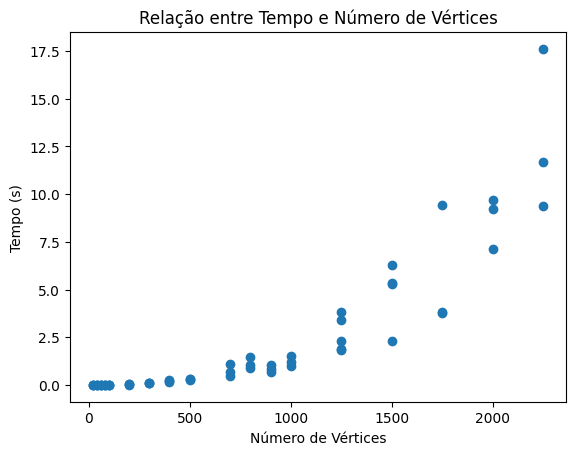

In [227]:
import os
import time
import matplotlib.pyplot as plt

def files_name(folder):
    file_names = []
    for file_name in os.listdir(folder):
        full_path = os.path.join(folder, file_name)
        if os.path.isfile(full_path):
            file_names.append(file_name)
    return file_names



folder = 'agp2009a-simplerand'
file_names = files_name(folder)

t = []
num_v = []


for file in file_names:
    input = f"{folder}/{file}"
    poly = Polygon(input)
    t_i = time.time()
    result = triangulate(poly)
    t_f = time.time()
    t.append(t_f - t_i)
    num_v.append(len(poly.vertex_list))
print(len(num_v))
plt.scatter(num_v, t)

plt.title('Relação entre Tempo e Número de Vértices')
plt.xlabel('Número de Vértices')
plt.ylabel('Tempo (s)')

plt.show()




Referências:

https://www.geeksforgeeks.org/timing-functions-with-decorators-python/

https://www.geometrictools.com/Documentation/TriangulationByEarClipping.pdf

https://github.com/yaugenst/triangulation/tree/master

https://www.w3schools.com/css/css_colors_rgb.asp